Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 08: Segmentation

## Introduction

This week's sheet should be solved and handed in before the end of **Monday, January 27, 2025**. If you need help (and Google and other resources were not enough), consult the StudIP forum. Please upload your results to your group's Stud.IP folder.

## Exercise 0: Math recap (Covariance) [0 Points]

This exercise is intended to revise the notion of covariance, which will pop up in class soon. Check if you are comfortable with it. You don't need a deep understanding, but you should have got the basic ideas. If you have problems to answer these questions offhand, this is a good time to look terms up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What does *covariance* express? How can the covariance between two random variables be computed? What is the relation to *correlation*?

YOUR ANSWER HERE

**b)** What is the *covariance matrix*? What do the entries in this matrix represent? How is it computed?

YOUR ANSWER HERE

**c)** Create and plot two (1-dimensional) datasets with low covariance (use `plt.scatter`). Then do the same for two datasets with high covariance.

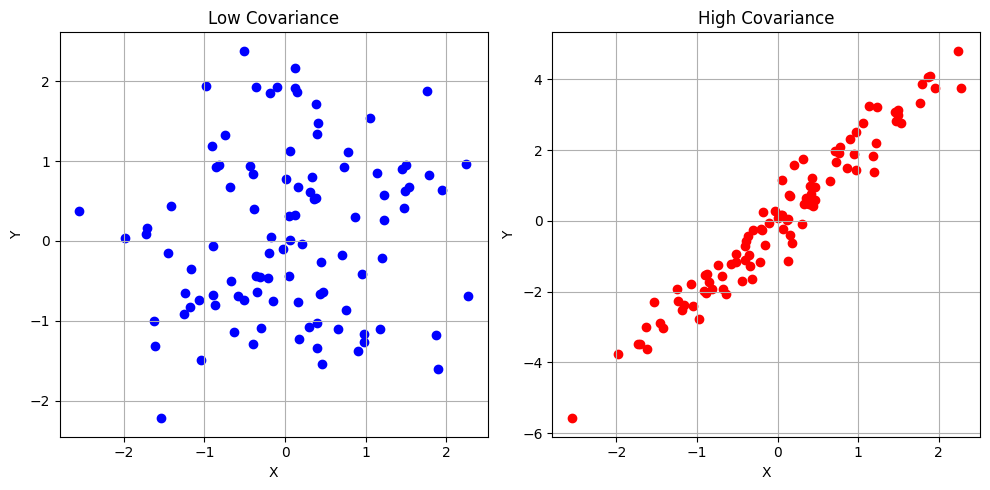

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Create random datasets with low covariance
np.random.seed(0)
x_low = np.random.randn(100)  # 100 random points for x
y_low = np.random.randn(100)  # 100 random points for y (independent of x)

# Plotting the low covariance datasets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_low, y_low, color='blue')
plt.title('Low Covariance')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Create datasets with high covariance (y = 2 * x + noise)
y_high = 2 * x_low + np.random.randn(100) * 0.5  # Adding small noise to keep it realistic

# Plotting the high covariance datasets
plt.subplot(1, 2, 2)
plt.scatter(x_low, y_high, color='red')
plt.title('High Covariance')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

plt.tight_layout()
plt.show()


## Assignment 1: Histogram-based segmentation (5 points)

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

Histogram-based segmentation is a technique used in image processing to separate different regions of an image based on intensity levels. It involves analyzing the histogram of pixel values to identify thresholds that separate different regions (e.g., foreground and background).

**Benefits**:  
- **Simple and efficient**: Easy to implement and computationally inexpensive
- **Robust for bimodal distributions**: Works well when image histograms have distinct peaks
- **Automatic thresholding**: Can be automated to avoid manual intervention

**Problems**:  
- **Sensitivity to noise**: Histograms can be affected by noise, leading to incorrect segmentation
- **Poor performance in multimodal distributions**: Works best with images having a clear distinction in pixel intensity levels
- **Requires proper threshold selection**: Improper thresholding can lead to over- or under-segmentation



### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scikit-image and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

1. **Otsu's Method**:
    Automatically determines an optimal threshold by maximizing the between-class variance. It finds the threshold that best separates the image into two classes: foreground and background, based on pixel intensity values. The method works by iterating through all possible threshold values and choosing the one that minimizes the intra-class variance.
   - Best for Bimodal histograms (where there are two distinct peaks representing foreground and background)
   - Effective for images with a clear foreground-background distinction

2. **Triangle Method**:
   - The Triangle method determines the threshold by drawing a line from the maximum of the histogram to the bottom-left and bottom-right corners of the histogram. The threshold is the point that is farthest from this line. This method is particularly useful for histograms where the background is dominant.
   - Best for images with a single peak in their histogram (often a background-dominated image)
   - Works well for histograms with a sine mode



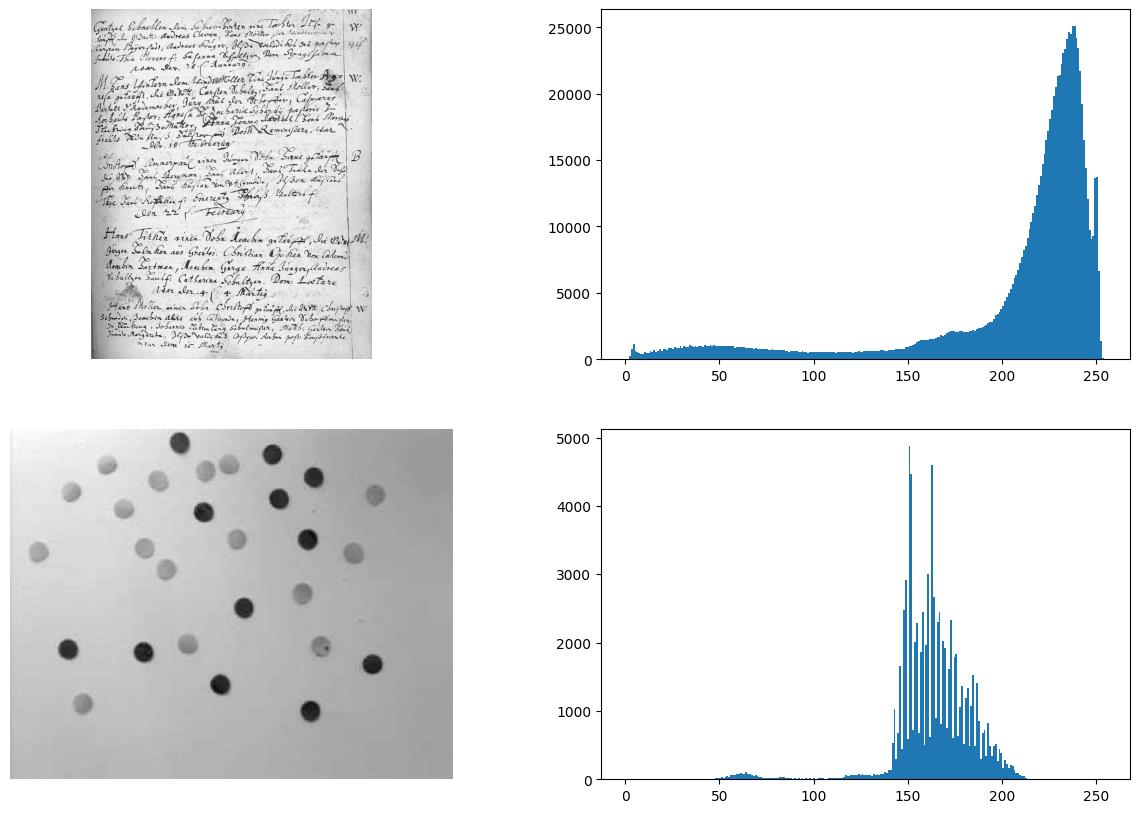

In [4]:
# Run this cell to get an impression of how the histograms look

%matplotlib inline
import matplotlib.pyplot as plt
from imageio.v3 import imread

img1 = imread('images/schrift.png')
img2 = imread('images/pebbles.jpg') 

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.show()

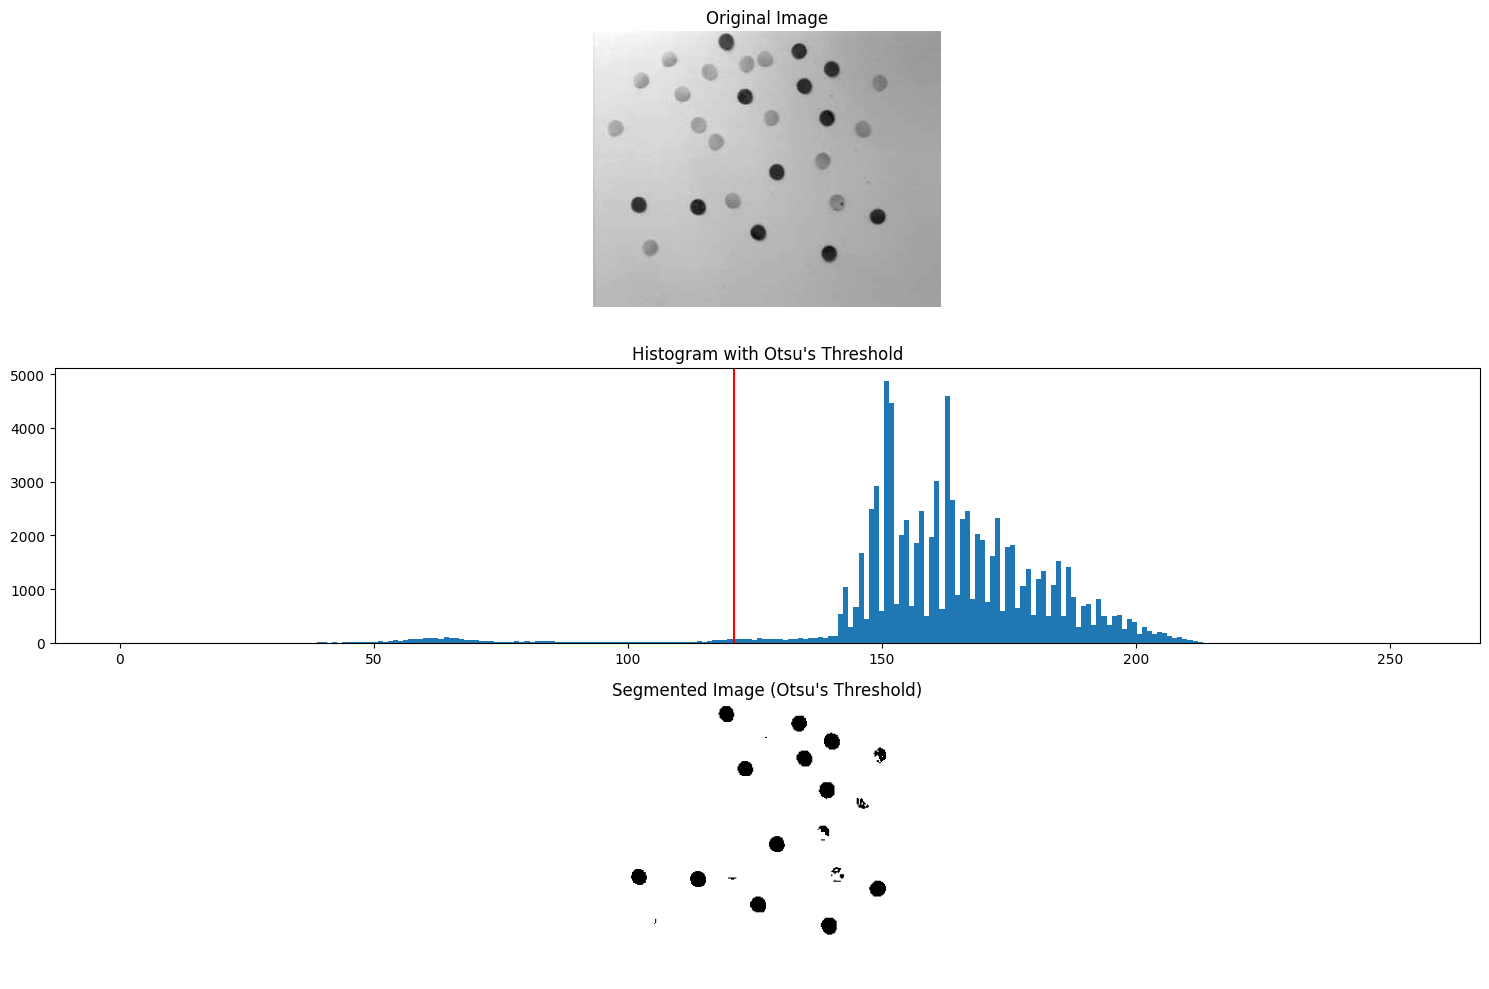

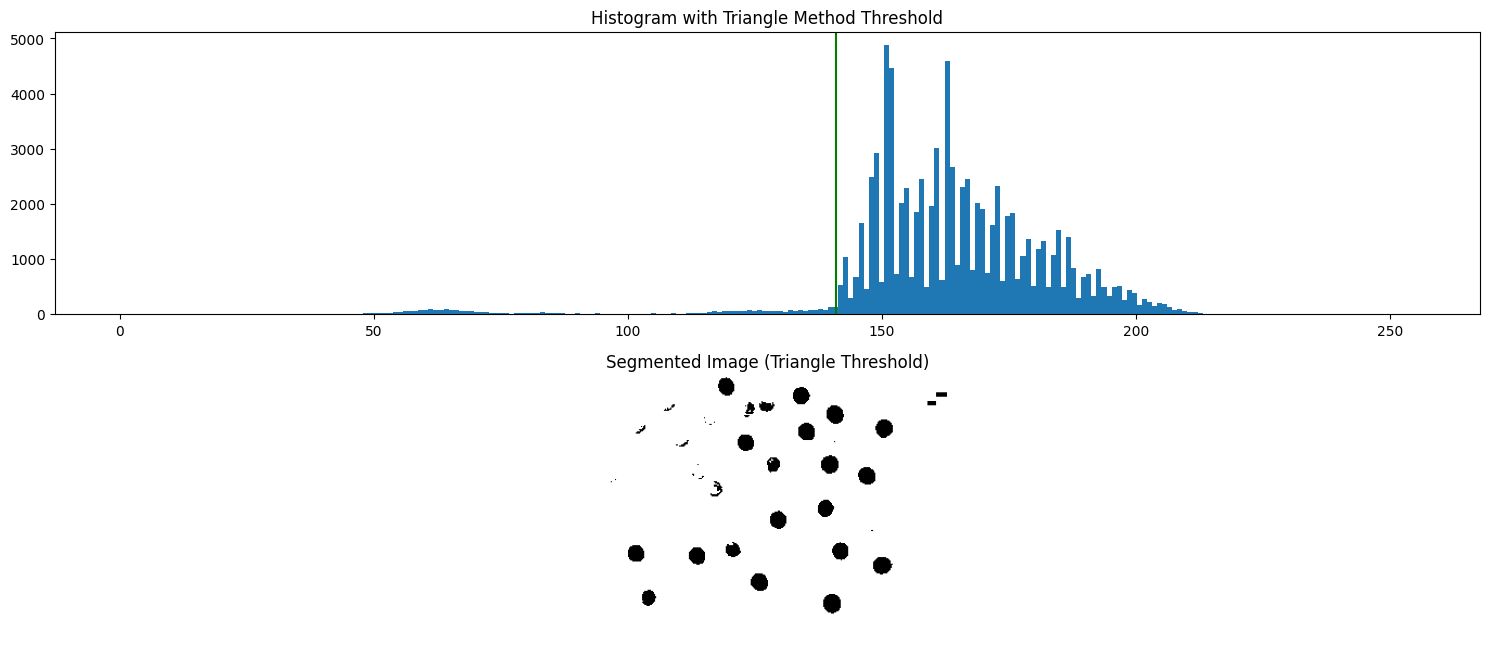

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio.v3 import imread
from skimage import filters

# Load image
img = imread('images/pebbles.jpg')  # 'pebbles.jpg' or 'schrift.png'

# Apply Otsu's thresholding method
thresh_otsu = filters.threshold_otsu(img)
segments_otsu = img > thresh_otsu

# Apply Triangle method for thresholding
thresh_triangle = filters.threshold_triangle(img)
segments_triangle = img > thresh_triangle

# Plotting the results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(3, 1, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Original Image')

# Histogram and Otsu's Threshold
plt.subplot(3, 1, 2)
plt.hist(img.flatten(), 256, (0, 255))
plt.axvline(thresh_otsu, color='r')
plt.title("Histogram with Otsu's Threshold")

# Thresholded image using Otsu's method
plt.subplot(3, 1, 3)
plt.axis('off')
plt.imshow(segments_otsu, cmap='gray')
plt.title("Segmented Image (Otsu's Threshold)")

plt.tight_layout()
plt.show()

# The Triangle method
plt.figure(figsize=(15, 10))

# Histogram and Triangle Method Threshold
plt.subplot(3, 1, 2)
plt.hist(img.flatten(), 256, (0, 255))
plt.axvline(thresh_triangle, color='g')
plt.title("Histogram with Triangle Method Threshold")

# Thresholded image using Triangle method
plt.subplot(3, 1, 3)
plt.axis('off')
plt.imshow(segments_triangle, cmap='gray')
plt.title("Segmented Image (Triangle Threshold)")

plt.tight_layout()
plt.show()


### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-09 slide 11), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`. You may use filter functions from scikit-image for this exercise.

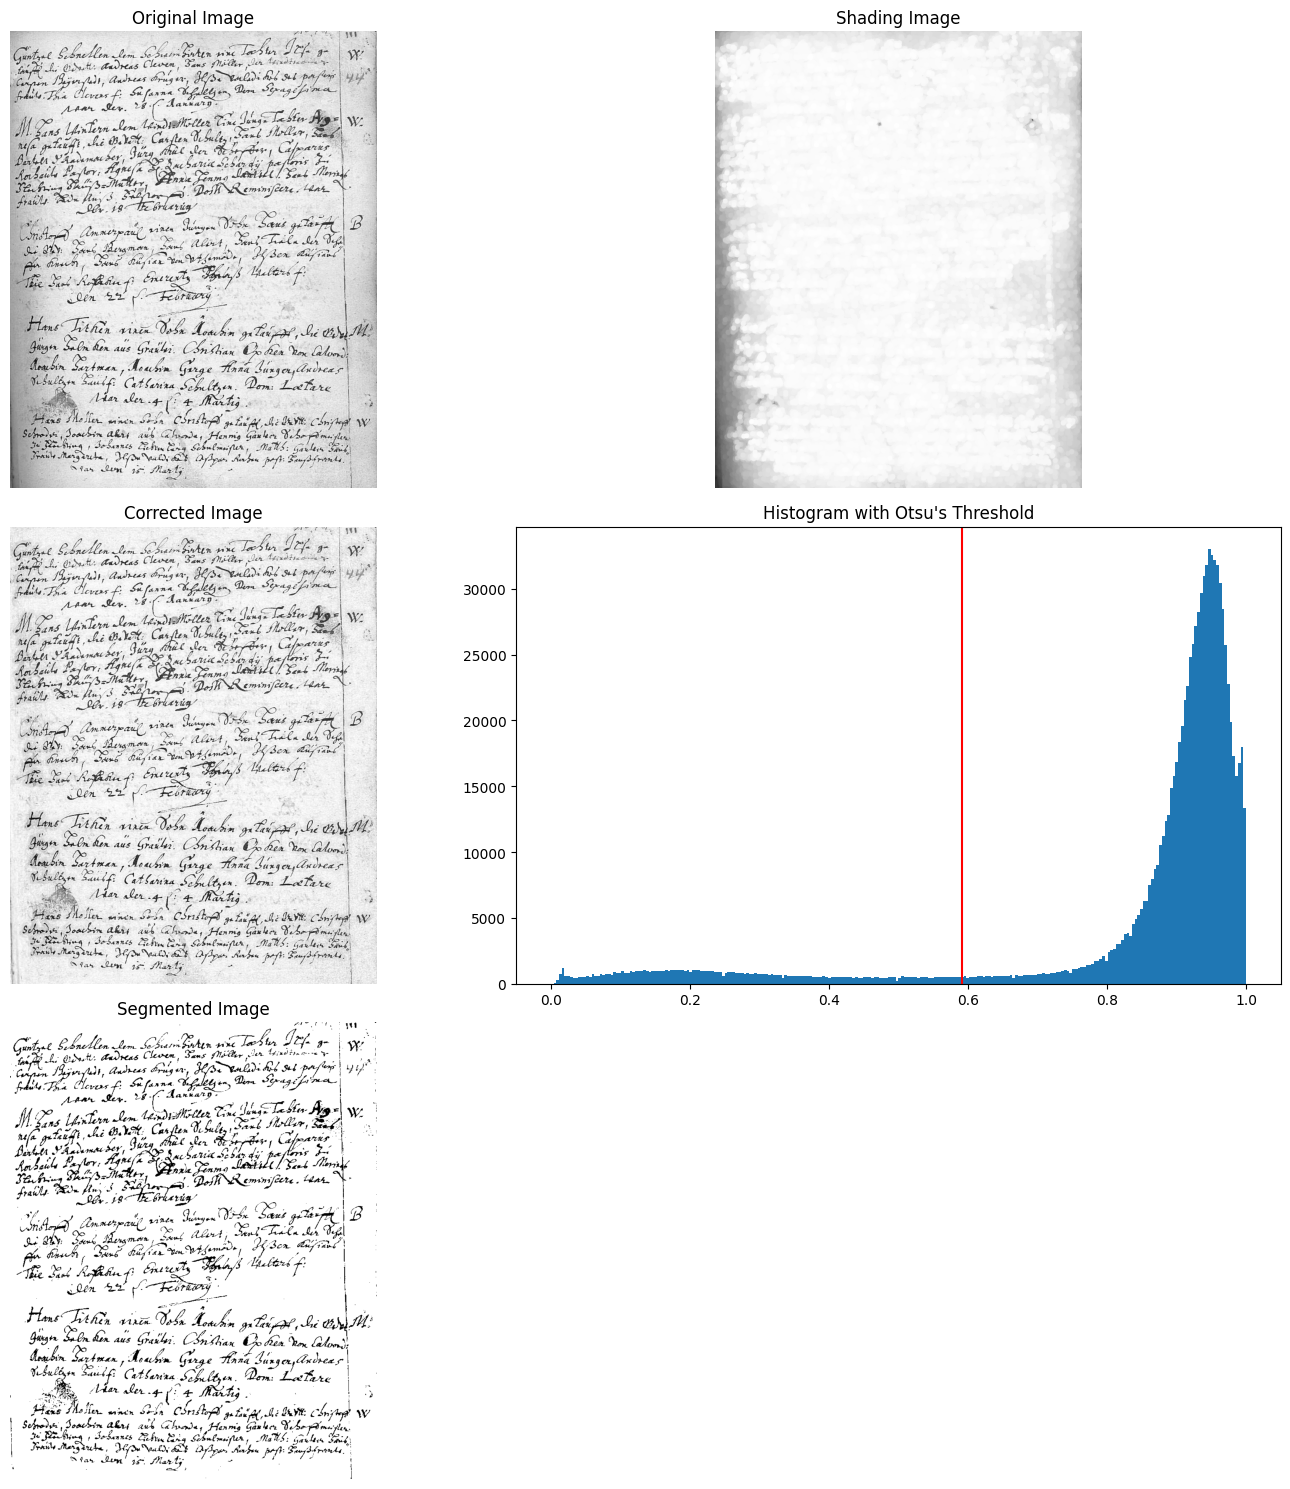

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread
from skimage import filters
from skimage.morphology import disk

# Load the image ('schrift.png' or 'pebbles.jpg')
img = imread('images/schrift.png').astype(float)/255

# Compute the shading image using a maximum filter
# We use a disk of radius 6 (for a 13x13 window size) as the structuring element
shading_image = filters.rank.maximum(img, disk(6))

# Normalize the shading image
shading_image_normalized = shading_image / np.max(shading_image)

# Correct the original image by multiplying with the shading image
corrected_image = img / shading_image_normalized

# Perform segmentation (use a thresholding method like Otsu here)

thresh = filters.threshold_otsu(corrected_image)
segmented_image = corrected_image > thresh

# Plotting the results
plt.figure(figsize=(15, 15))

# Original image
plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Shading image
plt.subplot(3, 2, 2)
plt.axis('off')
plt.imshow(shading_image_normalized, cmap='gray')
plt.title('Shading Image')

# Corrected image
plt.subplot(3, 2, 3)
plt.axis('off')
plt.imshow(corrected_image, cmap='gray')
plt.title('Corrected Image')

# Histogram and Otsu's threshold on corrected image
plt.subplot(3, 2, 4)
plt.hist(corrected_image.flatten(), bins=256, range=(0, 1))
plt.axvline(thresh, color='r')
plt.title("Histogram with Otsu's Threshold")

# Segmented Image
plt.subplot(3, 2, 5)
plt.axis('off')
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')

plt.tight_layout()
plt.show()

## Assignment 2: Pyramid representation (5 points)

**a)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-09 slide 35).

The **Gaussian pyramid** is a multi-scale representation of an image where each level of the pyramid contains a progressively lower resolution version of the original image. It is constructed by repeatedly applying **Gaussian blurring** and **downsampling** the image.

#### **Reduce Operation**
The **reduce** operation is used to downsample the image to a smaller size. This operation typically involves two steps:
1. **Gaussian Blurring**: The image is blurred using a Gaussian filter to smooth out the high-frequency noise
2. **Downsampling**: After blurring, the image is downsampled (typically by a factor of 2 in each dimension), i.e., every second pixel in both directions is taken from the blurred image

#### **Low-pass Filtering**
Low-pass filtering refers to filtering out high-frequency components (like sharp edges and noise) from an image, leaving only the low-frequency components (such as smooth regions and gradual transitions). This is typically achieved using a **Gaussian filter**, which smooths the image and removes fine details

#### **Why use Low-pass Filtering in Pyramid Construction?**
When constructing the Gaussian pyramid, low-pass filtering is essential because:
- **It prevents aliasing**: Aliasing happens when high-frequency components in the image are not properly filtered before downsampling, leading to visual artifacts. The Gaussian filter removes these high-frequency components, ensuring that downsampling results in a smooth and accurate lower-resolution image
- **It improves efficiency**: By eliminating unnecessary high-frequency details, the pyramid focuses on the essential, low-frequency content at each level

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from imageio.v3 import imread

# Function to plot pyramid-like structure
def plot_pyramid(pyramid_levels, operation_name="Operation"):
    plt.figure(figsize=(12, 12))
    
    # Plot the largest image (first image)
    plt.imshow(np.flipud(pyramid_levels[0]))  # Flip the first image (original)
    
    # Add a blue frame around the largest image
    plt.plot([0, pyramid_levels[0].shape[1]], [0, 0], color='blue', linewidth=2)  # Top
    plt.plot([0, pyramid_levels[0].shape[1]], [pyramid_levels[0].shape[0], pyramid_levels[0].shape[0]], color='blue', linewidth=2)  # Bottom
    plt.plot([0, 0], [0, pyramid_levels[0].shape[0]], color='blue', linewidth=2)  # Left
    plt.plot([pyramid_levels[0].shape[1], pyramid_levels[0].shape[1]], [0, pyramid_levels[0].shape[0]], color='blue', linewidth=2)  # Right
    
    # Plot the smaller images in the pyramid
    for i, level in enumerate(pyramid_levels[1:], start=1):
        y_offset = 0  # Keep at the top part of the previous image
        x_offset = 0  # Keep at the left edge (upper-left corner)
        
        # Plot the smaller version at its position
        plt.imshow(level, extent=[x_offset, x_offset + level.shape[1], y_offset, y_offset + level.shape[0]])

        # Add a blue frame around the smaller image
        plt.plot([x_offset, x_offset + level.shape[1]], [y_offset, y_offset], color='blue', linewidth=2)  # Top
        plt.plot([x_offset, x_offset + level.shape[1]], [y_offset + level.shape[0], y_offset + level.shape[0]], color='blue', linewidth=2)  # Bottom
        plt.plot([x_offset, x_offset], [y_offset, y_offset + level.shape[0]], color='blue', linewidth=2)  # Left
        plt.plot([x_offset + level.shape[1], x_offset + level.shape[1]], [y_offset, y_offset + level.shape[0]], color='blue', linewidth=2)  # Right
    
    # Set title and turn off axes
    plt.title(f"Image Pyramid with {operation_name} Operation")
    plt.axis('off')
    plt.show()

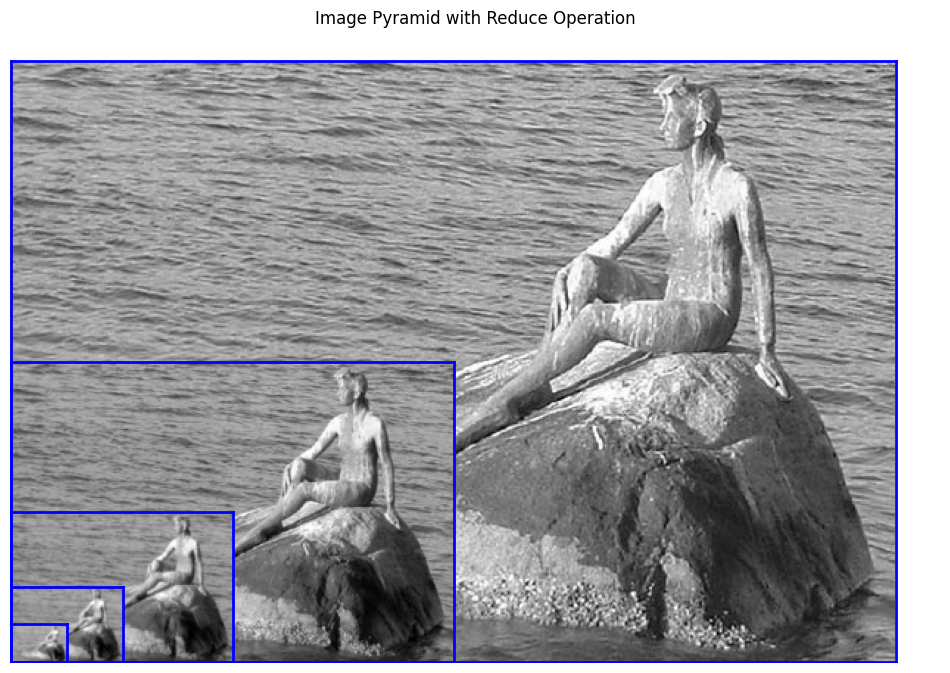

In [106]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio.v3 import imread

# Load the image
img = imread('images/mermaid.png')

# Function to apply the reduce operation (Gaussian blur + downsampling)
def reduce(image):
    # Apply Gaussian blur (low-pass filter)
    blurred_image = ndimage.gaussian_filter(image, sigma=1)  # Apply Gaussian blur with a standard deviation of 1
    
    # Downsample the image (reduce size by a factor of 2)
    reduced_image = blurred_image[::2, ::2]  # Take every second pixel
    
    return reduced_image

# Apply the reduce operation to generate a Gaussian pyramid (example with 4 levels)
pyramid_image = img.copy()  # Start with the original image

# Generate the pyramid by repeatedly applying the reduce operation
pyramid_levels = [pyramid_image]
for _ in range(4):  # Generate 4 levels of the pyramid
    pyramid_levels.append(reduce(pyramid_levels[-1]))

# Use the function to plot the pyramid with the reduce operation
plot_pyramid(pyramid_levels, operation_name="Reduce")

**b)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement (not using the library function;-) the **expand** operation and generate an image similar to the one on (CV-09 slide 37).

Remark: for producing the final image, do not start with the original image, but with a reduced version.

The **expand** operation **reproduces a larger image** from a smaller one. It involves **interpolating pixels** from the smaller image to generate the larger image, typically using Gaussian or binomial filtering for smoothness.

The **reduce** Operation involves **downsampling** which is discarding information. Once pixels are removed, there isn't enough data to perfectly recover the original image, making the operation **irreversible**.


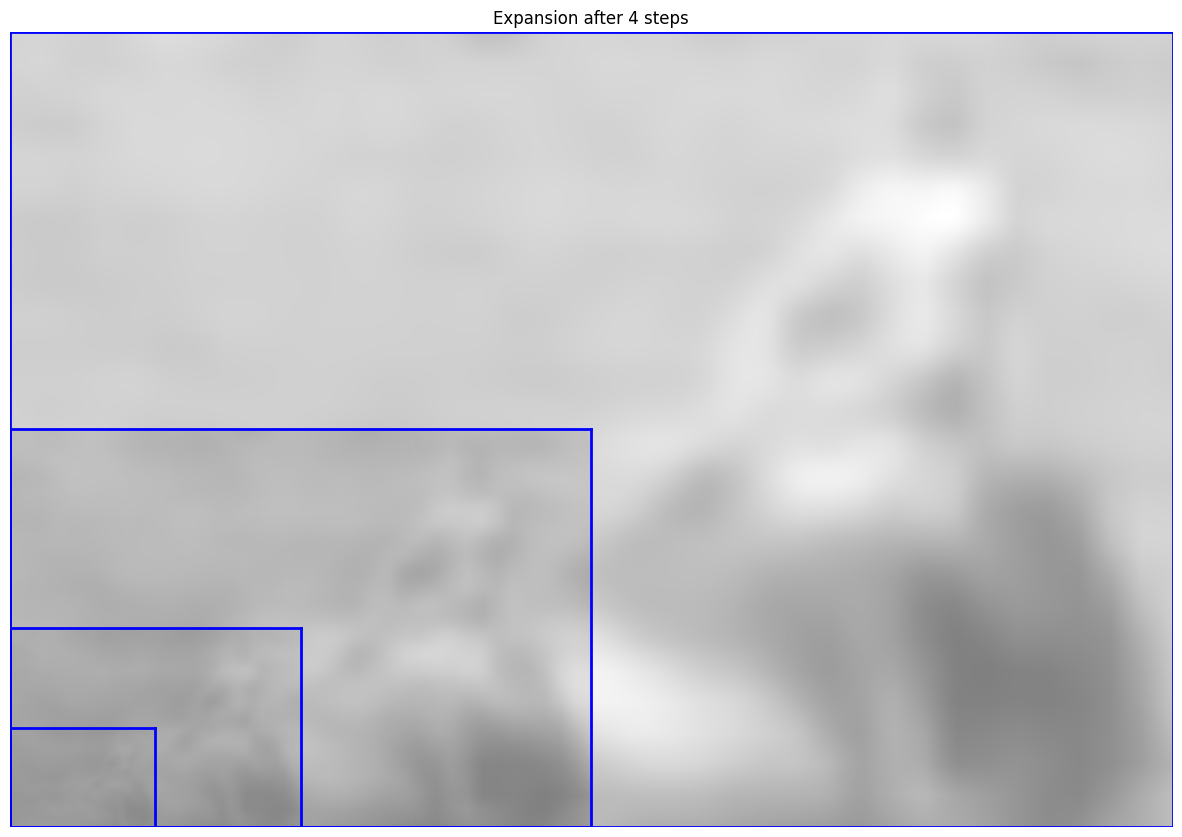

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from imageio.v3 import imread

steps = 4

# Function to apply the expand operation (using bilinear interpolation with Gaussian-like weights)
def expand(image, new_shape):
    old_height, old_width = image.shape
    new_height, new_width = new_shape
    
    # Create the row and column indices for the old image
    row_indices = np.linspace(0, old_height - 1, new_height)
    col_indices = np.linspace(0, old_width - 1, new_width)
    
    # Create meshgrid of indices for interpolation
    row_indices_grid, col_indices_grid = np.meshgrid(row_indices, col_indices, indexing='ij')
    
    # Get the four nearest neighbors' integer indices (flooring)
    row0 = np.floor(row_indices_grid).astype(int)
    row1 = np.clip(row0 + 1, 0, old_height - 1)
    col0 = np.floor(col_indices_grid).astype(int)
    col1 = np.clip(col0 + 1, 0, old_width - 1)
    
    # Get the values of the 4 neighboring pixels
    I00 = image[row0, col0]
    I01 = image[row0, col1]
    I10 = image[row1, col0]
    I11 = image[row1, col1]
    
    # Compute the weights for interpolation using Gaussian-like weights (similar to binomial filter)
    row_weight = row_indices_grid - row0
    col_weight = col_indices_grid - col0
    
    # Perform bilinear interpolation
    expanded = (I00 * (1 - row_weight) * (1 - col_weight) +
                I01 * (1 - row_weight) * col_weight +
                I10 * row_weight * (1 - col_weight) +
                I11 * row_weight * col_weight)
    
    return expanded

# Load the image
img = imread('images/mermaid.png')

# Function to apply the reduce operation (Gaussian blur + downsampling)
def reduce(image):
    # Apply Gaussian blur (low-pass filter)
    blurred_image = ndimage.gaussian_filter(image, sigma=1)  # Apply Gaussian blur with a standard deviation of 1
    
    # Downsample the image (reduce size by a factor of 2)
    reduced_image = blurred_image[::2, ::2]  # Take every second pixel
    
    return reduced_image

# Apply the reduce operation to generate a Gaussian pyramid (example with 4 levels)
pyramid_image = img.copy()  # Start with the original image

# Generate the pyramid by repeatedly applying the reduce operation
pyramid_levels = [pyramid_image]
for _ in range(4):  # Generate 4 levels of the pyramid
    pyramid_levels.append(reduce(pyramid_levels[-1]))

# Get the most reduced image (last level of the pyramid)
reduced_image = pyramid_levels[-1]

# Create a figure for plotting the expansion process
plt.figure(figsize=(15, 12))

# Start with the most reduced image and expand it in steps
expanded_image = reduced_image
for step in range(steps):
    final_height = expanded_image.shape[0] * 2
    final_width = expanded_image.shape[1] * 2
    
    # Perform the expansion
    expanded_image = expand(expanded_image, (final_height, final_width))
    
    # Plot each expansion step in the top-left corner (0, 0) with transparency
    plt.imshow(expanded_image, alpha=0.5, extent=[0, expanded_image.shape[1], 0, expanded_image.shape[0]])

    # Get the current image dimensions to draw the frame
    height, width = expanded_image.shape
    
    # Add a blue frame around the image (top, bottom, left, right)
    plt.plot([0, width], [0, 0], color='blue', linewidth=2)  # Top
    plt.plot([0, width], [height, height], color='blue', linewidth=2)  # Bottom
    plt.plot([0, 0], [0, height], color='blue', linewidth=2)  # Left
    plt.plot([width, width], [0, height], color='blue', linewidth=2)  # Right
    
    # Title for each step
    plt.title(f"Expansion after {step + 1} steps")
    plt.axis('off')

plt.show()

**c)** What is the *Laplacian pyramid*? What is it used for? Compute the Laplacian pyramid and generate an image similar to the one on (CV-09 slide 40).

The **Laplacian Pyramid** is a multi-scale image representation created by taking the difference between an image and its expanded version (using a Gaussian pyramid). It highlights the details and edges of the image at different scales. It efficiently captures high-frequency components while discarding low-frequency information.

**Key Uses:**
- **Image compression**: Reduces data by storing only the differences between levels
- **Image blending**: Combines images seamlessly at different resolutions
- **Edge detection**: Extracts fine details at multiple scales


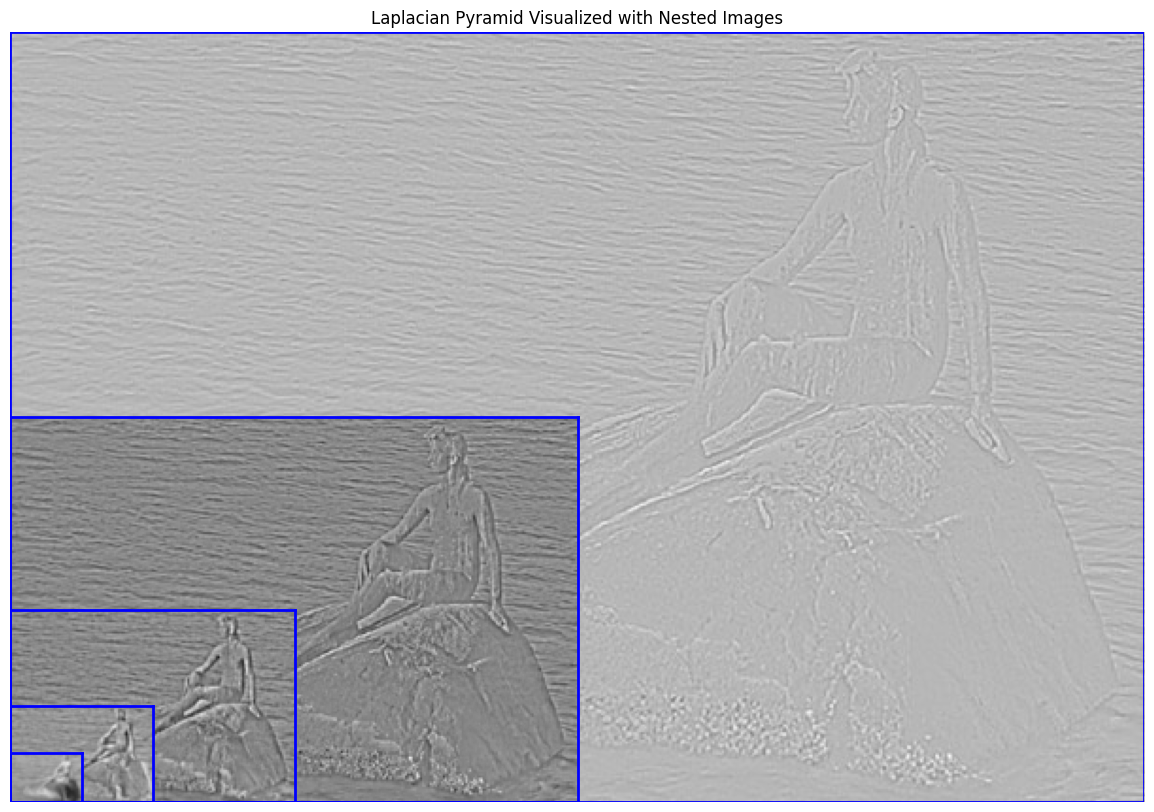

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from imageio.v3 import imread

# Function to apply the expand operation using bilinear interpolation with Gaussian-like weights
def expand(image, new_shape):
    old_height, old_width = image.shape
    new_height, new_width = new_shape
    
    # Create the row and column indices for the old image
    row_indices = np.linspace(0, old_height - 1, new_height)
    col_indices = np.linspace(0, old_width - 1, new_width)
    
    # Create a meshgrid of indices for interpolation
    row_indices_grid, col_indices_grid = np.meshgrid(row_indices, col_indices, indexing='ij')
    
    # Get the four nearest neighbors' integer indices (flooring)
    row0 = np.floor(row_indices_grid).astype(int)
    row1 = np.clip(row0 + 1, 0, old_height - 1)
    col0 = np.floor(col_indices_grid).astype(int)
    col1 = np.clip(col0 + 1, 0, old_width - 1)
    
    # Get the values of the 4 neighboring pixels
    I00 = image[row0, col0]
    I01 = image[row0, col1]
    I10 = image[row1, col0]
    I11 = image[row1, col1]
    
    # Compute the weights for interpolation using Gaussian-like weights (similar to binomial filter)
    row_weight = row_indices_grid - row0
    col_weight = col_indices_grid - col0
    
    # Perform bilinear interpolation
    expanded = (I00 * (1 - row_weight) * (1 - col_weight) +
                I01 * (1 - row_weight) * col_weight +
                I10 * row_weight * (1 - col_weight) +
                I11 * row_weight * col_weight)
    
    return expanded

# Function to apply the reduce operation (Gaussian blur + downsampling)
def reduce(image):
    # Apply Gaussian blur (low-pass filter)
    blurred_image = ndimage.gaussian_filter(image, sigma=1)  # Apply Gaussian blur with a standard deviation of 1
    
    # Downsample the image (reduce size by a factor of 2)
    reduced_image = blurred_image[::2, ::2]  # Take every second pixel
    
    return reduced_image

# Function to generate the Laplacian pyramid
def laplacian_pyramid(image, levels=4):
    # Generate Gaussian pyramid
    pyramid = [image]
    for _ in range(levels):
        pyramid.append(reduce(pyramid[-1]))
    
    # Generate Laplacian pyramid
    laplacian_pyramid = []
    for i in range(levels):
        # Expand the (i+1)th level and subtract from the ith level of the pyramid
        expanded_image = expand(pyramid[i + 1], pyramid[i].shape)
        laplacian_image = pyramid[i] - expanded_image
        laplacian_pyramid.append(laplacian_image)
    
    # The last level is just the Gaussian image (no expansion possible)
    laplacian_pyramid.append(pyramid[-1])
    
    return laplacian_pyramid

# Load the image
img = imread('images/mermaid.png')

# Generate Laplacian pyramid
laplacian_levels = laplacian_pyramid(img, levels=4)

# Plot each level of the Laplacian pyramid inside each other with a blue frame
plt.figure(figsize=(15, 10))

# Start with the smallest level and progressively add larger ones
for i, laplacian_image in enumerate(laplacian_levels):
    height, width = laplacian_image.shape
    
    # Plot the Laplacian image with transparency
    plt.imshow(laplacian_image, alpha=0.5, extent=[0, width, 0, height])
    
    # Add a blue frame around the current image (top, bottom, left, right)
    plt.plot([0, width], [0, 0], color='blue', linewidth=2)  # Top
    plt.plot([0, width], [height, height], color='blue', linewidth=2)  # Bottom
    plt.plot([0, 0], [0, height], color='blue', linewidth=2)  # Left
    plt.plot([width, width], [0, height], color='blue', linewidth=2)  # Right
    
    # Update extent for the next level to be nested inside the current image
    if i < len(laplacian_levels) - 1:
        # Each next image is nested within the previous one
        next_height, next_width = laplacian_levels[i + 1].shape
        plt.imshow(laplacian_levels[i + 1], alpha=0.5, extent=[0, next_width, 0, next_height])
        
plt.title("Laplacian Pyramid Visualized with Nested Images")
plt.axis('off')
plt.show()


## Assignment 3: Region merging (5 points)

Implement the *region merging* algorithm (CV-09 slide 43) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

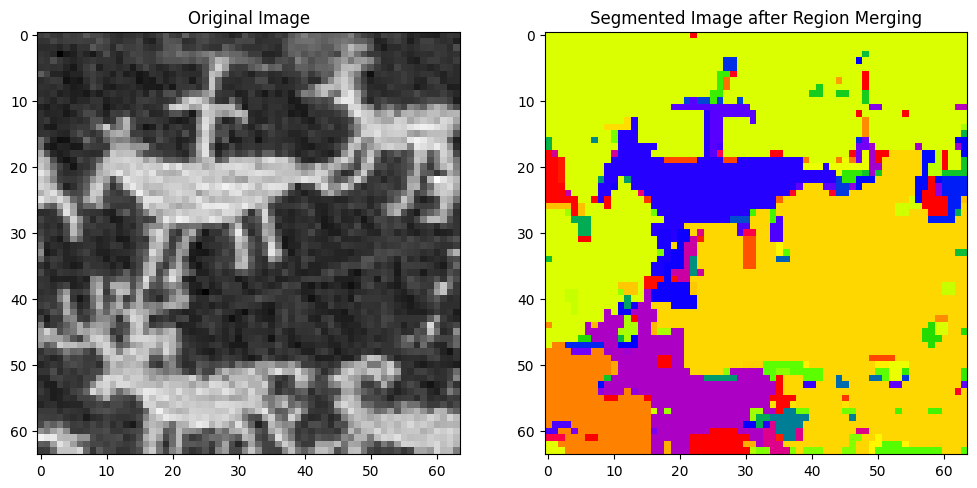

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread

# Load and process the image
img = imread('./images/segments.png')
img = img[64:128, 64:128]  # Extract a small region for testing

# Convert image to float32 for safe arithmetic operations
img = img.astype(np.float32)

# Define the region merging function
def region_merging(img, threshold=10):
    # Initialize labels (each pixel is its own segment)
    labels = np.arange(img.size).reshape(img.shape)
    
    # Get the shape of the image
    rows, cols = img.shape
    
    # Function to check the homogeneity condition
    def is_homogeneous(region1, region2):
        return np.abs(region1 - region2) <= threshold
    
    # Continue merging regions until no more merges are possible
    merged = False
    while True:
        merged = False
        for i in range(rows):
            for j in range(cols):
                # Check the neighborhood (down and right)
                if i + 1 < rows:
                    if labels[i, j] != labels[i + 1, j] and is_homogeneous(img[i, j], img[i + 1, j]):
                        # Merge regions
                        old_label = labels[i + 1, j]
                        labels[labels == old_label] = labels[i, j]
                        merged = True
                if j + 1 < cols:
                    if labels[i, j] != labels[i, j + 1] and is_homogeneous(img[i, j], img[i, j + 1]):
                        # Merge regions
                        old_label = labels[i, j + 1]
                        labels[labels == old_label] = labels[i, j]
                        merged = True
        # If no merges happened, exit the loop
        if not merged:
            break
    
    return labels

# Apply region merging to the image
label = region_merging(img, threshold=18)

# Display the result
plt.figure(figsize=(12, 12))
plt.gray()
plt.subplot(1, 2, 1)
plt.imshow(img.astype(np.uint8))  # Convert back to uint8 for display
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(label, cmap='prism')
plt.title("Segmented Image after Region Merging")
plt.show()



## Assignment 4: Scale space (5 points)

**a)** What is a scale space? How does it relate to an image pyramid? How is it computed?

For some background on scale spaces, you may have a look at the entry on [Scale space](http://kth.diva-portal.org/smash/get/diva2:441147/FULLTEXT01.pdf) in the Encyclopedia  of  Computer Science and Engineering.

A **scale space** is a representation of an image at multiple scales (or levels of resolution), used to analyze structures at different levels of Detail. The main idea is to smooth the image progressively at different scales to capture both fine and coarse features.

### Relation to Image Pyramid

- **Image Pyramid**: Discrete, with fixed levels 
- **Scale Space**: Continuous, with an infinite number of scales 

An **Image Pyramid** is a multi-resolution representation of an image, created by repeatedly downscaling the image (by factors such as 2) and storing each version. It is closely related to scale space as both represent an image at multiple resolutions, but the **Image Pyramid** is discrete, with fixed levels and **Scale Space** is continuous, with an infinite number of scales.

### Computation of Scale Space

Scale space is computed by progressively applying a **Gaussian filter** with increasing standard deviation $ \sigma $ at each scale. The process can be described as:

$$
L(x, y, \sigma) = G(x, y, \sigma) * I(x, y)
$$

Where:
- $ L(x, y, \sigma) $ is the image at scale $ \sigma $,
- $ G(x, y, \sigma) $ is the Gaussian kernel with standard deviation $ \sigma $,
- $ * $ denotes convolution,
- $ I(x, y) $ is the original image.

The result is a set of images with progressively more blurred versions of the original image, capturing features at different scales.


**b**) Explain the figure depicted on CV-09 slide 41. How are the zero crossings obtained? Why do they tend to form loops? How can the depicted information be used for segmentation?


1. **How are the Zero Crossings obtained?**
   - Zero crossings are identified by computing the **second derivative** (Laplacian) of the signal at different scales
   - The points where the **second derivative** crosses zero (changes sign) are considered **zero crossings**. These points typically correspond to **edges** or transitions in the image 

2. **Why do Zero Crossings tend to form loops?**
   - **Zero crossings form loops** because of the nature of the Laplacian operator and the way the second derivative behaves. The signal oscillates and, at certain scales, these oscillations result in **loops** or circular patterns in the detected zero crossings. This is a characteristic feature when detecting complex, multi-scale edges or structures in the signal.

3. **How can the depicted information be used for segmentation?**
   - **Segmentation** can be achieved by using **zero crossings** as **edge indicators**. Since zero crossings mark transitions in the image, they can be used to segment different regions or boundaries in the image
   - By analyzing the zero crossings across different scales, one can detect **multi-scale edges** and use these transitions to define regions for segmentation, enabling the identification of boundaries between distinct objects or areas in an image

- Zero crossings are detected by analyzing the second derivative (Laplacian) at multiple scales
- They form loops due to oscillatory behavior at certain scales
- These zero crossings are used in segmentation to identify boundaries and segment the image into distinct regions based on transitions in intensity


**c)** Implement the computation of a scale space. Also include code for highlighting the zero crossings at different scales to produce a visualization similar to the figure on CV-09 slide 41.

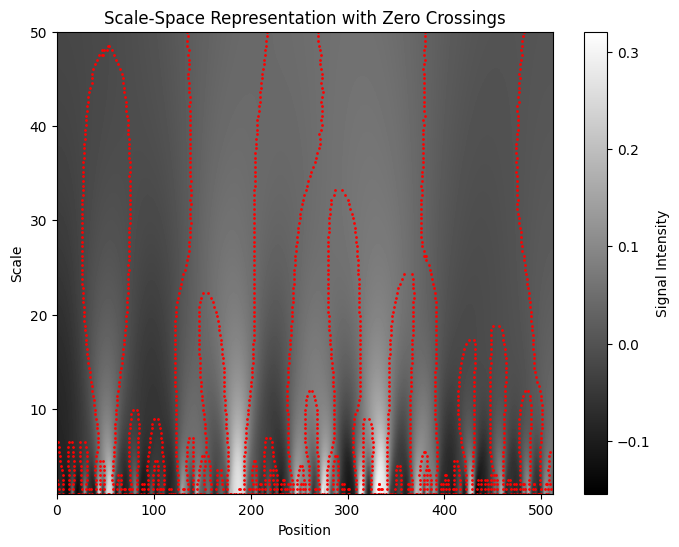

In [18]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load the image
img = imageio.imread('images/NewspaperRock.png') / 255.0
img -= img.mean()

# Extract a 1D signal (e.g., middle row)
signal = img[img.shape[0] // 2, :]

# Parameters for scale space analysis
scales = np.linspace(1, 50, 100)  # Continuous scale range
scale_space = []
zero_crossings = []

# Compute scale space and zero crossings
for scale in scales:
    # Smooth signal with Gaussian filter at current scale
    smoothed_signal = gaussian_filter1d(signal, sigma=scale)
    scale_space.append(smoothed_signal)

    # Compute the second derivative
    second_derivative = np.gradient(np.gradient(smoothed_signal))

    # Find zero crossings
    zero_cross = np.where(np.diff(np.sign(second_derivative)))[0]
    zero_crossings.append(zero_cross)

# Convert scale space to numpy array
scale_space = np.array(scale_space)

# Plot scale-space representation
plt.figure(figsize=(8, 6))
plt.imshow(scale_space, cmap='gray', aspect='auto', origin='lower', extent=[0, len(signal), scales[0], scales[-1]])
plt.colorbar(label='Signal Intensity')
plt.xlabel('Position')
plt.ylabel('Scale')

# Overlay zero crossings
for i, zero_cross in enumerate(zero_crossings):
    scale = scales[i]
    for zc in zero_cross:
        plt.plot(zc, scale, 'r.', markersize=2)

plt.title('Scale-Space Representation with Zero Crossings')
plt.show()